In [3]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [4]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [5]:
# df_train

In [6]:
# train_transaction.head()

In [ ]:
# train_identity.head()

In [ ]:
# train_transaction.info();

In [ ]:
# train_identity.info();

In [ ]:
# df_train.shape

In [ ]:
# train_transaction_sum = train_transaction.duplicated().sum()
# train_identity_sum = train_identity.duplicated().sum()
# columns = train_transaction.columns
# print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# # print('Train feature columns:\n', list(columns))

### Assigning columns to specific lists (cat, num, date, etc.)

In [7]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = ['isFraud']

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i + col_target)))

# col_all = col_cat + col_num + col_date + col_bool + col_id + col_target
# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

Total columns: 220


In [8]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
                
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 10:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()
# df_null_info

# determine what to do with columns that have too many unique values... obviously.. types of solutions
# would be to put "MISSING" for those that dont have an email address... but you will need to evaluate 
# and make instead a counter of unique values, then append that and look at the CSV via google sheets. use 
# something like the code below 

# Planning - our preprocessing method must automatically drop missing values, but we can't do that because
# we need to see about filling them in first, then decide if we need to drop them. Right now, we need to
# create a dataframe that shows unique values for each column with missing values. 

# we need to look at each variable and see if it's unique or categorical. We need to use possibly PCA...? How do
# we handle so many variables? 

There were 195 columns with null values.


In [9]:
pp.df_train = pp.impute_features()

label encoded: addr1 unique 333
label encoded: addr2 unique 75
dummies encoded: ProductCD unique 5
label encoded: P_emaildomain unique 59
label encoded: card1 unique 13553
label encoded: card2 unique 501
label encoded: card3 unique 115
dummies encoded: card4 unique 4
label encoded: card5 unique 120
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 228)


In [11]:
df_features = pp.df_train.copy()

In [12]:
fraud_summary = df_features.groupby('isFraud')
fraud_summary.mean().to_csv('/Users/krahman/work/fraud_detection/saved_files/fraud_summary.csv')

In [13]:
corr = df_features.corr()

In [14]:
corr.to_csv('/Users/krahman/work/fraud_detection/saved_files/corr_matrix.csv')

,isFraud,V40,V44,V45,V51,V52,V86,V87
isFraud,1.000000,0.174672,0.217870,0.235436,0.182007,0.195492,0.222343,0.221568
V40,0.174672,1.000000,0.225232,0.271469,0.744831,0.745758,0.217055,0.213533
V44,0.217870,0.225232,1.000000,0.905537,0.257145,0.251881,0.604776,0.515480
V45,0.235436,0.271469,0.905537,1.000000,0.257400,0.296102,0.585396,0.608788
V51,0.182007,0.744831,0.257145,0.257400,1.000000,0.954315,0.212453,0.196567
V52,0.195492,0.745758,0.251881,0.296102,0.954315,1.000000,0.215183,0.207535
V86,0.222343,0.217055,0.604776,0.585396,0.212453,0.215183,1.000000,0.850021
V87,0.221568,0.213533,0.515480,0.608788,0.196567,0.207535,0.850021,1.000000


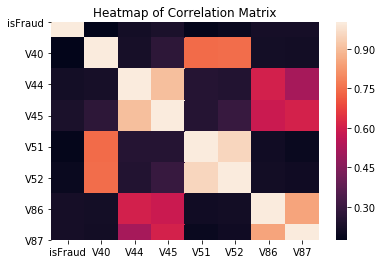

In [15]:
corr2 = corr[corr['isFraud']>.17]
corr2 = corr2.loc[:,corr2.index]

sns.heatmap(corr2,
           xticklabels=corr2.columns.values,
           yticklabels=corr2.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr2

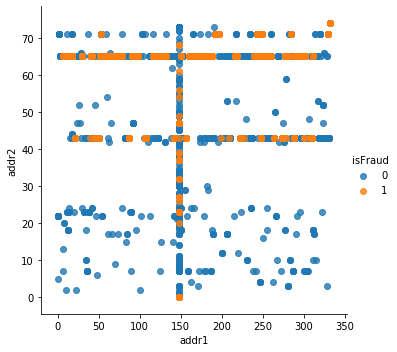

In [16]:
# NEXT, go through regplot eda with randy. 
sns.lmplot(x='addr1', y='addr2', data=df_features,
           fit_reg=False, hue='isFraud')
plt.show()
# if we can take addr1 and addr2 and bin them, we can create a more highly correlated variables.. 
# right now we have too many categorical variables for addr1. Lets look at addr1 150 and see fraud counts...
# we know that PCA is necessary and it's going to pick up what's important anyway so right now we need
# to leverage the features that PCA will eventually drop and see if we can create better features all together
# I think there is a lot more valuable info to be found in the addresses. The question is, what is really the
# impact of binning? 

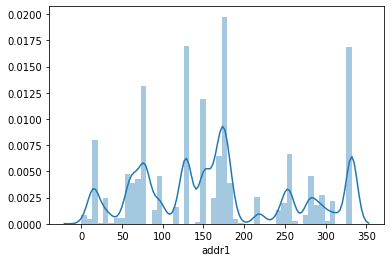

In [17]:
sns.distplot(df_features.addr1)
plt.show()

### Feature Engineering

In [18]:
# create feature percentage occurrance. Then we will ohe this new feature.. we cant do that..
# better to bin these values... 
# we could even do KNN for these features.. 
# one problem we have is we are training on our training set, but then we are predicting on what we trained..
# so our decision tree isnt correct.. we should be figuring that out almost... first.. lets finish this first.. 
dict_addr1 = {}
for val in df_features.addr1.unique():
    val_percentage = df_features[df_features['addr1']==val].shape[0]/df_features.shape[0]
    dict_addr1.update([(val, val_percentage)])
    
dict_addr2 = {}
for val in df_features.addr1.unique():
    val_percentage = df_features[df_features['addr2']==val].shape[0]/df_features.shape[0]
    dict_addr2.update([(val, val_percentage)])
    
df_features['addr3'] = df_features['addr1'].map(dict_addr1)
df_features['addr4'] = df_features['addr2'].map(dict_addr1)

# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

# sns.distplot(df_features['addr3'])
# plt.title('Addr3 Distribution')
# plt.show()

# sns.lmplot(x='addr3', y='addr4', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr3 versus addr4')
# plt.show()

In [35]:
# sns.lmplot(x='addr1', y='addr2', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr1 versus addr2')
# plt.show()

# sns.distplot(df_features.addr1)
# plt.title('Addr1 Distribution')
# plt.show()

# sns.distplot(df_features['addr3'])
# plt.title('Addr3 Distribution')
# plt.show()

# sns.lmplot(x='addr3', y='addr4', data=df_features,
#            fit_reg=False, hue='isFraud')
# plt.title('addr3 versus addr4')
# plt.show()

In [ ]:
# # c is num, ex, how many addresses associated with card
# col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# # d is num, time/days between transactions
# col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# # m is date of transaction
# col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# # v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
# col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# # i is identity information like network and digital signature associated with transaction
# col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# # ca is cat, card information such as card type, etc. 
# col_card = [ca for ca in df_train.columns if ca.startswith('card')]

In [ ]:
# # c is num, ex, how many addresses associated with card
# col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# # d is num, time/days between transactions
# col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# # m is date of transaction
# col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# # v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
# col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# # i is identity information like network and digital signature associated with transaction
# col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# # ca is cat, card information such as card type, etc. 
# col_card = [ca for ca in df_train.columns if ca.startswith('card')]
# # D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# # associated with card, M=True/False, V created features on ranking, counting, etc. 

# # column id and target
# col_id = ['TransactionID']
# col_target = ['isFraud']

# # converting categorical columns with numerical values to string types.
# col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
# for val in col_cat_to_obj:
#     df_train[val] = df_train[val].astype(str)

# # categorical columns
# col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# # C counter, D is time elapsed between transactions, V feature engineered variables by firm
# col_num = ['TransactionAmt'] + col_c + col_d + col_v

# # figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
# col_date = ['TransactionDT'] 

# # boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
# # col_bool = col_m

# # confirming all columns are accounted for
# print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i + col_target)))

# # col_all = col_cat + col_num + col_date + col_bool + col_id + col_target
# # columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType 

In [ ]:
# plt.scatter(X.card1, y)
# sns.regplot(x='card5_237.0', y='isFraud', data=pp.df_train, logistic=True, color='b')

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [72]:
X = df_features.drop(col_target, axis=1)
X = X.drop(col_id, axis=1)
y = df_features[col_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Test Dropping Features On Base Model

In [ ]:
###########
# label encoded: addr1 unique 333
# dummies encoded: addr2 unique 75
# dummies encoded: ProductCD unique 5
# dummies encoded: P_emaildomain unique 59
# label encoded: card1 unique 13553
# label encoded: card2 unique 501
# label encoded: card3 unique 115
# dummies encoded: card4 unique 4
# label encoded: card5 unique 120
# dummies encoded: card6 unique 4
# dummies encoded: M1 unique 2
# dummies encoded: M2 unique 2
# dummies encoded: M3 unique 2
# dummies encoded: M4 unique 3
# dummies encoded: M6 unique 2
# y_test = pp.df_train[col_target] #.rename(columns=['isFraud'])
# y_test = pd.Series(y_test)
# y_test

In [ ]:
# # Testing dropping columns
# model_lr_results = pd.DataFrame()
# model_recall = []
# model_precision = []
# model_auc_score = []

# for col in ['addr1', 'addr2', 'P_emaildomain', 'card1', 'card2', 'card3', 'card5']:
#     print('Dropping: ', col)
#     X_drop = X.drop(col, axis=1)
# #     X_drop = X_drop.loc[:10000,:]
#     y_drop = y#[:10001]
    
#     scaled_X = StandardScaler().fit_transform(X_drop)
#     # pca
#     pca = PCA()
#     pcomponents = pca.fit_transform(scaled_X)
#     X_pca = pd.DataFrame(data=pcomponents)
#     # split
#     X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y_drop, test_size=0.1, random_state=42)
#     # smote
#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
#     X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)
#     # model fit
#     model_lr_pca = LogisticRegression(random_state=42)
#     model_lr_pca.fit(X_train_res, y_train_res)
#     # predict
#     y_pred_prob = model_lr_pca.predict_proba(X_pca)
#     y_pred_class = binarize(y_pred_prob, 0.5)[:,1]
#     # scoring
#     model_recall.append(recall_score(y_drop, y_pred_class))
#     model_precision.append(precision_score(y_drop, y_pred_class))
#     model_auc_score.append(roc_auc_score(y_drop, y_pred_prob[:,1]))
#     print(confusion_matrix(y_drop, y_pred_class))
#     print(classification_report(y_drop, y_pred_class))
#     print('AUC: ', roc_auc_score(y_drop, y_pred_prob[:,1]))

# model_recall = pd.Series(model_recall, name='recall')
# model_precision = pd.Series(model_precision, name='precision')
# model_auc_score = pd.Series(model_auc_score, name='auc_score')
# model_results_final = pd.concat([model_auc_score, model_recall, model_precision],axis=1)
# model_results_final

# # it's apparent that label encoding on some of these don't really matter and if we drop them.. it doesn't really
# # matter.. 
# # dropping these columns has little impact with logistic regression.. 

# # tune logistic regression

In [ ]:
### DELETE

# model_lr_results = pd.DataFrame()
# model_recall = []
# model_precision = []
# model_auc_score = []

#     model_recall.append(recall_score(y_drop, y_pred_class))
#     model_precision.append(precision_score(y_drop, y_pred_class))
#     model_auc_score.append(roc_auc_score(y_drop, y_pred_prob[:,1]))

# model_recall = pd.Series(model_recall, name='recall')
# model_precision = pd.Series(model_precision, name='precision')
# model_auc_score = pd.Series(model_auc_score, name='auc_score')
# model_results_final = pd.concat([model_auc_score, model_recall, model_precision],axis=1)
# model_results_final

In [ ]:
# ### DELETE

# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# df_temp = pd.DataFrame(pca.explained_variance_ratio_)
# df_temp[0:20]
# pd.DataFrame(pca.components_, columns=list(X_temp.columns), index=range(0,225))
# pca.components_

## Applying PCA (2 components)

In [ ]:
# standardizing our data, which is required for PCA.
scaled_X = StandardScaler().fit_transform(X)
pd.DataFrame(scaled_X, columns=X.columns).head()

In [ ]:
# PCA instantiate and fit 
pca = PCA(n_components=2)
pcomponents = pca.fit_transform(scaled_X)
X_pca = pd.DataFrame(data = pcomponents, columns=['PC1','PC2'])
print(X_pca.shape)
X_pca.head()

In [ ]:
# two principal components scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y['isFraud'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

# explaining vaariance
print('Variance ratio:')
print(pca.explained_variance_ratio_)
# interpreting principal components
print('\nPrincipal components explained:')
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

## Applying PCA to all features (all components)

In [ ]:
pca2 = PCA().fit(scaled_X)
# pca2.explained_variance_ratio_
# np.cumsum(pca2.explained_variance_ratio_)

In [ ]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Credit Card Fraud Explained Variance')
plt.show()

## Model w/ SMOTE only - base model

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Apply SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train1, y_train1)

In [ ]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_res, y_train_res) 

In [ ]:
# predicting on test set w/o PCA
print("Predicting using only SMOTE (and w/o PCA)\n")
y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr.score(X_test1, y_test1))
print(recall_score(y_test1, y_pred_test1))
print("\nConfusion Matrix")
print(confusion_matrix(y_test1, y_pred_test1))
print('\nClassification Report:\n')
print(classification_report(y_test1, y_pred_test1))

# predicting on original dataset
print("Whole dataset:")
y_pred = model_lr.predict(X)
print("\nTest Results")
print(model_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))

## Logistic Regression w/PCA  w/SMOTE

### EDA

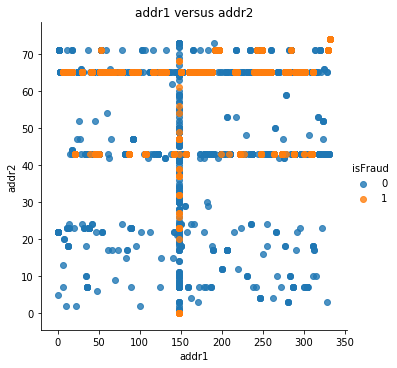

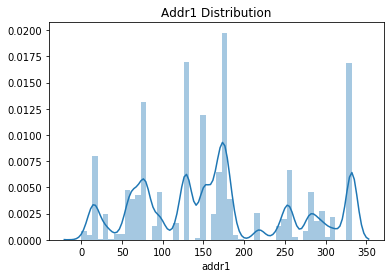

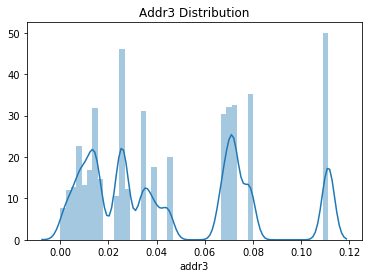

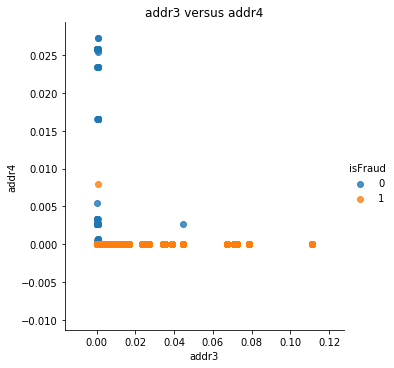

In [36]:
sns.lmplot(x='addr1', y='addr2', data=df_features,
           fit_reg=False, hue='isFraud')
plt.title('addr1 versus addr2')
plt.show()

sns.distplot(df_features.addr1)
plt.title('Addr1 Distribution')
plt.show()

sns.distplot(df_features['addr3'])
plt.title('Addr3 Distribution')
plt.show()

sns.lmplot(x='addr3', y='addr4', data=df_features,
           fit_reg=False, hue='isFraud')
plt.title('addr3 versus addr4')
plt.show()

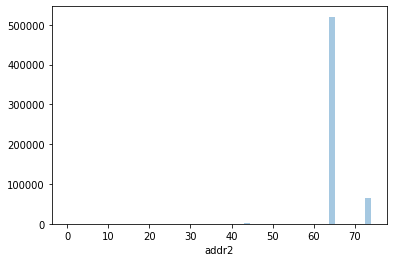

65    520481
74     65706
43      3084
71       638
23        91
47        82
7         55
22        47
10        33
17        25
18        20
50        17
42        17
24        16
30        12
20        11
73        11
3         11
41        10
49        10
Name: addr2, dtype: int64

In [50]:
sns.distplot(df_features.addr2, kde=False)
plt.show()
df_features.addr2.value_counts(ascending=False)[:20]

In [ ]:
for val in df_features.addr2.unique():
    if df_features.addr2.loc[]

In [49]:
print(df_features.addr2.unique())
df_features.addr2.sort_values(ascending=True)[:20]

[65 74 71 25 43 73 30 47 23  4 22  2 15  7  6 10 52 42  3 31 17 50 33 59
 66 48 53 13 41 16  8 21 20 12  5 35 62 56 24 64 34 49 14 51 45 39 36 38
 28 57  0 54 72 46 18 19 27 55 58 68 60 63 61 29 26 32  9 11 67 44 70  1
 40 37 69]


434945    0
128406    0
434948    0
128411    0
434949    0
123762    0
434950    0
434946    0
564197    1
517980    1
16544     2
25622     2
235075    2
40952     2
110253    3
110268    3
46916     3
110259    3
20892     3
110291    3
Name: addr2, dtype: int64

### Feature Engineering

In [87]:
df_features = pp.df_train.copy()

dict_addr1 = {}
for val in df_features.addr1.unique():
    val_percentage = df_features[df_features['addr1']==val].shape[0]/df_features.shape[0]
    dict_addr1.update([(val, val_percentage)])
    
dict_addr2 = {}
for val in df_features.addr1.unique():
    val_percentage = df_features[df_features['addr2']==val].shape[0]/df_features.shape[0]
    dict_addr2.update([(val, val_percentage)])
    
df_features['addr3'] = df_features['addr1'].map(dict_addr1)
df_features['addr4'] = df_features['addr2'].map(dict_addr1)

In [88]:
X = df_features.drop(col_target, axis=1)

X = X.drop('addr1', axis=1)
X = X.drop('addr2', axis=1)

X = X.drop(col_id, axis=1)
y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [97]:
X = X.drop('addr3', axis=1)
X = X.drop('addr4', axis=1)

In [ ]:
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [90]:
list(X.columns)

['TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'P_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D10',
 'D11',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',

In [98]:
import time
start_time = time.time()

# applying PCA
scaled_X = StandardScaler().fit_transform(X)
# pca = PCA(n_components=250)
pca = PCA()
pcomponents = pca.fit_transform(scaled_X)
X_pca = pd.DataFrame(data=pcomponents)

In [99]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pca, y, test_size=0.1, random_state=42)

In [100]:
# applying SMOTE
sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train2, y_train2)

In [101]:
# fit logistic regression
model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1)
model_lr_pca_sm.fit(X_train_res, y_train_res)
# predict
y_pred = model_lr_pca_sm.predict(X_train2)
# time
elapsed_time = time.time() - start_time
print('\nTime elapsed:', elapsed_time / 60)


Time elapsed: 29.862392286459606


In [102]:
print(confusion_matrix(y_train2, y_pred))

[[396629 116303]
 [  4545  14009]]


In [103]:
print(classification_report(y_train2, y_pred))
# NEXT, we need to create another feature that gives the number a higher ranking based on percentage of isfraud
# cases... create this as addr5 and 6 then test. 

              precision    recall  f1-score   support

           0       0.99      0.77      0.87    512932
           1       0.11      0.76      0.19     18554

    accuracy                           0.77    531486
   macro avg       0.55      0.76      0.53    531486
weighted avg       0.96      0.77      0.84    531486



In [85]:
# create addr5 addr6 as imputed whole variables. 
# RESULTS: addr5, addr6

# RESULTS: with only addr3, addr4
# [[396868 116064]
#  [  4544  14010]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: w/o addr1, addr2, addr3, addr4
# [[396629 116303]
#  [  4545  14009]]

#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.76      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with only addr1, addr2
# [[396803 116129]
#  [  4555  13999]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

# RESULTS: with addr1, addf2, addr3, addr4
# [[396877 116055]
#  [  4549  14005]]
#               precision    recall  f1-score   support

#            0       0.99      0.77      0.87    512932
#            1       0.11      0.75      0.19     18554

#     accuracy                           0.77    531486
#    macro avg       0.55      0.76      0.53    531486
# weighted avg       0.96      0.77      0.84    531486

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)

In [29]:
# y_pred = model_lr_pca_sm.predict(X_pca)

# cross validation
result = cross_val_score(model_lr_pca_sm, X_train2, y_train2, cv=10, n_jobs=-1, scoring='recall_score')
result.mean()

ValueError: 'recall_score' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


### Predict Proba

In [ ]:
%matplotlib inline
plt.rcParams['font.size'] = 14

In [ ]:
y_pred_prob = model_lr_pca.predict_proba(X_pca)
plt.hist(y_pred_prob[:,1], bins=8)
plt.xlim(0,1)
plt.title("Histogram of Probability of Fraud")
plt.xlabel("Predicted probability of Fraud")
plt.ylabel("Frequency")

In [ ]:
y_pred_prob = model_lr_pca.predict_proba(X_pca)
y_pred_class = binarize(y_pred_prob, 0.5)[:,1]

In [ ]:
print(confusion_matrix(y, y_pred_class))
print(classification_report(y, y_pred_class))

In [ ]:
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("ROC curve for fraud detection classifier")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.grid(True)

In [ ]:
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')

In [ ]:
evaluate_threshold(.5)
evaluate_threshold(.2)
evaluate_threshold(.1)

print(roc_auc_score(y, y_pred_prob[:,1]))
# NEXT CONT, from here on youtube vid 49:00. once we finish the video
# go back to improving the model using feature selection, eda, 
# and decision tree eda

In [ ]:
y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
print('y_pred_actual on test set\n')
print(y_pred_actual[0:10])
print(confusion_matrix(y_test2, y_pred_actual))
print(classification_report(y_test2, y_pred_actual))

print('y_pred_proba\n')
y_pred_proba = model_lr_pca.predict_proba(X_test2)
y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
print(y_pred_class[0:10])
print(confusion_matrix(y_test2, y_pred_class))
print(classification_report(y_test2, y_pred_class))

In [ ]:
y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
print('Logistic Regression')
print('y_pred_actual full data set\n')
print(y_pred_actual[0:10])
print(confusion_matrix(y, y_pred_actual))
print(classification_report(y, y_pred_actual))

print('y_pred_proba full data set\n')
y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
print(y_pred_class[0:10])
print(confusion_matrix(y, y_pred_class))
print(classification_report(y, y_pred_class))

In [ ]:
##################

In [ ]:
# predicting on test set w/o PCA
print("Predicting using Logistic Regression, PCA, SMOTE\n")
y_pred_pca_sm = model_lr_pca.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_lr_pca.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca_sm))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca_sm))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca_sm))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca_sm_whole = model_lr_pca.predict(X_pca)
print("\nTest Results")
print(model_lr_pca.score(X_pca, y))
print(recall_score(y, y_pred_pca_sm_whole))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca_sm_whole))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca_sm_whole))

### Model - Decision Tree - w/PCA w/SMOTE

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model_dt_pca_smote = DecisionTreeClassifier(random_state=42)
model_dt_pca_smote.fit(X_train_res, y_train_res)

In [ ]:
# predicting on test set w/o PCA
print("Predicting using PCA\n")
y_pred_pca = model_dt_pca_smote.predict(X_test2)
# y_pred_test1 = model_lr.predict(X_test1)
print("Test set:")
print("Validation results")
print(model_dt_pca_smote.score(X_test2, y_test2))
print(recall_score(y_test2, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y_test2, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y_test2, y_pred_pca))

# predicting on original dataset
print("Whole dataset:")
y_pred_pca = model_dt_pca_smote.predict(X_pca)
print("\nTest Results")
print(model_dt_pca_smote.score(X_pca, y))
print(recall_score(y, y_pred_pca))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred_pca))
print('\nClassification Report:\n')
print(classification_report(y, y_pred_pca))

In [ ]:
#####################

In [ ]:
print("Variance ratio:")
print(pca.explained_variance_ratio_)
print("\nPrincipal components explained:")
pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

In [ ]:
# # explaining variance
# print('Variance ratio:')
# print(pca.explained_variance_ratio_)
# # interpreting principal components
# print('\nPrincipal components explained:')
# pd.DataFrame(pca.components_, columns=list(X.columns), index=('PC1', 'PC2'))

# # # predicting on original dataset
# # y_pred = clf_lr.predict(X)
# # print("\nTest Results")
# # print(clf_lr.score(X, y))
# # print(recall_score(y, y_pred))
# # print("\nConfusion Matrix")
# # print(confusion_matrix(y, y_pred))
# # print('\nClassification Report:\n')
# # print(classification_report(y, y_pred))

In [ ]:
# scaled_X2 = StandardScaler().fit_transform(X)
# pca3 = PCA(n_components=275)
# pcomponents = pca3.fit_transform(scaled_X2)
# X_pca = pd.DataFrame(data=pcomponents)

## Applying SMOTE

In [ ]:
# applying SMOTE to train set to correct class imbalance
sm = SMOTE(random_state=42, ratio = 1.0, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [ ]:
# fitting to residuals created by SMOTE
clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
clf_lr.fit(X_train_res, y_train_res);

In [ ]:
# predicting on test set
y_test_pred = clf_lr.predict(X_test)
print("Validation results")
print(clf_lr.score(X_test, y_test))
print(recall_score(y_test, y_test_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('\nClassification Report:\n')
print(classification_report(y_test, y_test_pred))

In [ ]:
# predicting on original dataset
y_pred = clf_lr.predict(X)
print("\nTest Results")
print(clf_lr.score(X, y))
print(recall_score(y, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y, y_pred))
print('\nClassification Report:\n')
print(classification_report(y, y_pred))

In [ ]:
# print("\nConfusion Matrix")
# print(confusion_matrix(y, y_pred))
# print('\nClassification Report:\n')
# print(classification_report(y, y_pred))

In [ ]:
# logistic regression
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
# clf.predict(X_test)
# clf.score(X_test, y_test)
# 0.7870216903822372 
# 0.8013998429794899 < 60
# 0.5085411973583608 < 1000
# 0.63556873752431 < 60 dropped col_id

In [ ]:
# clf.predict_proba(X_test)

In [ ]:
# # confusion matrix
# y_pred = clf.predict(X_test)
# print(confusion_matrix(y_test, y_pred))

In [ ]:
# print(classification_report(y_test, y_pred))

In [ ]:
# read up on class im balance and correct it. 
# perhaps we can one by one run our model through a decision tree and do one hot encoding for one big 
# categorical column at a time lets say 13,000 unique values, then we can see of the new 13,000 columns we
# have if any actually have predictive value for us. 

In [ ]:
# import statsmodels.api as sm

# # define iv
# iv = X.columns

# # fit the logistic regression function
# logReg = sm.Logit(y_train, X_train)
# answer = logReg.fit()

In [ ]:
# df_result['Fraud']

In [ ]:
# for val in pp.df_train.columns:
#     if (pp.df_train[pp.df_train[val]=='nan'].shape[0]) > 0:
#         print(val)

In [ ]:
# # pp.df_train
# # lets find out which columns are object... 
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val].dtype=='O':
#         list_col_object.append(val)
        
# pp.df_train[list_col_object]
# # for card2, nan was the most commonly seen value... so it imputed that...? 

In [ ]:
# for val in pp.df_train.columns:
#     if pp.df_train[pp.df_train[val]=='nan']

In [ ]:
# list_col_object = []
# for val in pp.df_train.columns:
#     if pp.df_train[val]:
#         list_col_object.append(val)

In [ ]:
# np.sum(pp.df_train[list_col_object].isnull())
# pp.df_train['card2'].unique()
# pp.df_train[df_train['card2']=='nan']

In [ ]:
# sum(np.sum(pp.df_train.isnull()))

In [ ]:
# We need to clean the data before thinking about applying PCA. 
# 1. Determine which columns are continuous, which are ranking.
# 2. Determine which columns are bool (easy)
# 3. Determine which columns are categorical, then impute with pandas (we dont know which columns means what
#    so we cant assume True or better than False, etc.)
# 4. After 

# 1. impute all objects columns with one hot encoding
# 1.1 What's a categorical? 
# We know the V's are ranking.. we need to discern meaning, 

# 2. figure out if we should do pca next. we should do that next..
# 3. then stand up the model. 


In [ ]:
# plt.bar(df_train['V14'])
# sns.barplot(df_train['V196'])
# we need to imput the mode here.. 
# df_train['V14'].mode()
# df_train['V22'].unique()
# for val in col_v:
#     print(val)
#     print(df_train[val].unique())
# we ned to descern what is a 0 1 outcome then impute.

# col = 'V290'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# missing_val = np.sum(df_train[col].isnull())
# print('Missing values: ' + str(missing_val))
# print("REAL VALUE COUNTS: ")
# df_train[col].value_counts().head()

# col = 'card4'
# series_temp = df_train[col].fillna(df_train[col].mode()[0])
# plt.hist(series_temp);
# df_train[col].value_counts()

# col = 'D1'
# series_temp = df_train[col].fillna(df_train[col].mean())
# plt.hist(series_temp);
# df_train['D1'].value_counts()